## MIMIC-3 Analysis: More Feature Engineering, SCM's

Using the tools we developed last week we will do more feature engineering before developing a string of SCM's by the threshold hyperparameter. We note graphs are formatted for inclusion in our final report.

## Configuration

These cells remain largely the same as last week, although we will change the encoding cell later on.

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
% cd /content/drive/My Drive/SCIE3250 Journal/Week 9

In [0]:
# Need to restart runtime following this install
! pip install causalnex
! pip install --upgrade pandas==0.24.0  # We require this version of pandas

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
files.upload()

In [0]:
import pandas as pd
df = pd.read_csv('mimic_day_blocks_ARDS2.csv', delimiter=',')

Again we digitalise our discrete variables and create a copy dataframe we are free to edit destructively. This time we do not digitalise \``CHARTDATE`\` however; we intend to use it later on.

In [0]:
import numpy as np
df_enc = df.copy()

non_numeric_columns = ['GENDER', 'AGE_INTERVALS']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    df_enc[col] = le.fit_transform(df_enc[col])

## Feature Engineering, Imputation

We recall our procedure for preparing \``df_e`\` from last week:
* Run the copy and drop cell.
* If adding time series, run \``df_e = add_series_list([the series list])`\`.
* Run \``df_e = impute(df_e)`\`.
* Run the discretize and drop cell.

In [0]:
df_e = df_enc.copy()
drops = ['PaO2', 'FiO2', 'Tidal_ml', 'Plateau_Pressure_cmH2O', \
  'Total_PEEP_cmH2O', 'AGE_INTERVALS']
df_e = df_e.drop(columns=drops)

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

This week however, we would like to alter our features. For easy scaling and imputation we will enact our changes on \``df_enc`\`, remembering to add extra time series in the \``add_series_list`\` step. We also outline our intention to change to an object-oriented framework at a later stage given things take a little more scripting (ie reassignments) than necessary! For now we will continue with our procedural method however. As for last week, we describe our feature engineering steps in Latex for easy inclusion in our report.

% LATEX BEGINNING

In addition to temporal analysis we also wanted to consider two parameter interactions, between BMI and tidal volume as well as driving pressure. In particular we were interested in the effects of tidal volume and driving pressure relative to BMI. Accordingly we created two new parameters, $\frac{V_t}{BMI}$ and $\frac{P_d}{BMI}$ for which we then added temporal parameters, scaled and imputed as previously described. We also added driving pressure as a parameter for comparison with RSC. Finally we removed obsolete parameters as described in \textit{Table 2}. As a result our final dataset contained 1307 imputations or still around 1.2\% of the total values.

    \begin{longtable}{lp{10cm}}
        \toprule
        Parameter Group & Parameters\\
        \midrule
        Original & \url{ARDS}, \url{BMI}, \url{PaO2/FiO2}, \url{Tidal_ml}, \url{Plateau_Pressure_cmH2O},
        \url{Total_PEEP_cmH2O}, \url{Driving_Pressure}, \url{HCO3},  \url{PaCO2}, \url{Creatinine},
        \url{AGE}, \url{SEX}, \url{HADM_IM}, \url{CHARTDATE}\\
        \midrule
        Created & \url{Driving_Pressure}, \url{Tidal_ml/BMI}, \url{Driving_Pressure/BMI}\\
        \midrule
        Temporal & \url{PaO2/FiO2_Change}, \url{RSC_Change}, \url{Driving_Pressure_Change},
        \url{HCO3_Change}, \url{PaCO2_Change}, \url{Creatinine_Change}\\
        \midrule
        Removed & \url{Tidal_ml}, \url{Plateau_Pressure_cmH2O}, \url{Total_PEEP_cmH2O}\\
        \midrule
        Final & \url{ARDS}, \url{BMI}, \url{PaO2/FiO2}, \url{Driving_Pressure}, \url{HCO3},  \url{PaCO2},
        \url{Creatinine}, \url{Driving_Pressure}, \url{Tidal_ml/BMI}, \url{Driving_Pressure/BMI},
        \url{PaO2/FiO2_Change}, \url{RSC_Change}, \url{Driving_Pressure_Change}, \url{HCO3_Change},
        \url{PaCO2_Change}, \url{Creatinine_Change}, \url{AGE}, \url{SEX}, \url{HADM_IM}, \url{CHARTDATE}\\
        \bottomrule
        \caption{Parameters Throughout Data Preparation}
    \end{longtable}


% LATEX END

In [0]:
import numpy as np
df_enc = df.copy()

# Encode discrete variables
non_numeric_columns = ['GENDER', 'AGE_INTERVALS']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    df_enc[col] = le.fit_transform(df_enc[col])

# Create additional features
df_enc['Driving_Pressure'] = df_enc['Plateau_Pressure_cmH2O'] - \
  df_enc['Total_PEEP_cmH2O']
df_enc['Tidal_ml/BMI'] = df_enc['Tidal_ml']/df_enc['BMI']
df_enc['Driving_Pressure/BMI'] = df_enc['Driving_Pressure']/df_enc['BMI']

# Remove obsolete features
drops = ['PaO2', 'FiO2', 'Tidal_ml', 'Plateau_Pressure_cmH2O', \
  'Total_PEEP_cmH2O', 'AGE_INTERVALS']
df_enc = df_enc.drop(columns=drops)

In [0]:
def add_series_list(col_list, df=df_e):
  # Find the time series for a list of parameters and add to df_e
  for col in col_list:
    df[col + ' Change'] = find_series(col)

  return df.dropna()

In [0]:
def find_series(col, df=df_e):
  # Find daily flux in a given parameter
  diff_col = np.zeros(len(df[col]))
  diff_col[0] = np.nan
  diff_col = pd.Series(diff_col)
  

  for i in range(len(diff_col)-1, -1, -1):

    if i != 0:

      if df['HADM_ID'][i] == df['HADM_ID'][i-1]:
        diff_col[i] = df[col][i] - df[col][i-1]

      else:
        diff_col[i] = np.nan

  return diff_col

In [0]:
 def impute(df_e):
  # Replace infinities with nan
  df_e.replace([-np.inf, np.inf], np.nan, inplace=True)

  # Do not remove zeroes from discrete variables
  cols_disc = ['HADM_ID', 'CHARTDATE', 'ARDS', 'GENDER', 'AGE_INTERVALS']
  cols_cont = [i for i in df_e.columns if i not in cols_disc]

  from sklearn.preprocessing import scale

  # Replace outliers 3 standard devs or more away with nan, scale cont vars
  for col in cols_cont:
    df_e[col] = df_e[col].mask(df_e[col].values - df_e[col].mean() > \
      3*df_e[col].std(), other=np.nan)
    df_e[col] = scale(df_e[col])

  # Impute all nan with K clustering, not on variables that don't make sense
  from sklearn.impute import KNNImputer

  # Remove, store irrelevant columns
  store_vars = ['HADM_ID', 'CHARTDATE']
  store_inds = [df_e.columns.get_loc(i) for i in store_vars]
  df_store = df_e[store_vars]
  df_e = df_e.drop(columns=store_vars)

  # Copy df_e to check how many values are imputed
  df_check = df_e.copy()

  # Store parameter labels of df_e
  my_columns = df_e.columns

  # Impute over relevant columns
  imp = KNNImputer(missing_values=np.nan)
  df_e = pd.DataFrame(imp.fit_transform(df_e), columns=my_columns)

  # Count imputations
  num_imp = df_check.size - np.sum(np.sum(df_e.values==df_check.values))

  # Restore irrelevant columns in original order for ease of viewing
  for i in range(len(store_vars)):
    df_e.insert(store_inds[i], store_vars[i], df_store[store_vars[i]])

  return df_e

As a result of our changes, our process is now as follows. To reiterate, we intend to switch our functional approach to object-oriented at a later stage for easier presentation to an audience.

---



In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2', \
  'Driving_Pressure', 'Tidal_ml/BMI', 'Driving_Pressure/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

For the creation of our Bayesian network we will require discretised, classified data; we create the following classifier cell designed to be run after imputation.

## SCM

Our aim here will be to develop some interesting SCM's to analyse more closely next week. We will also aim to investigate the effects of the various features we have added.

In [0]:
! apt-get install -y graphviz-dev  # We require the developer version
! pip install pygraphviz

In [0]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.structure.notears import from_pandas

First of all we try without time series. Not intending to progress to a Bayesian network this week, we don't need to run the full discretiser cell.

From here on in, all graph commentary will be in Latex.

% LATEX BEGINNING

We begin exploring our dataset by developing SCM's excluding temporal parameters. From here on in we forbid all source nodes, \url{GENDER}, \url{AGE}, from being children of any other node and will delete trivial relations between created parameters and their components such as \url{Driving_Pressure/BMI} $\rightarrow$ \url{Driving_Pressure} and \url{Driving_Pressure} $\rightarrow$ \url{RSC}. Additionally we ban \url{ARDS} from being a parent of any other node.

% LATEX END

In [0]:
df_e = df_enc.copy()

df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

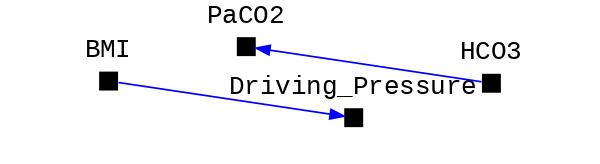

In [214]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.5)
# We know that these are isolates or undesirable so remove them for viewing
sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'ARDS', 'AGE', 'GENDER',
  'Creatinine', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

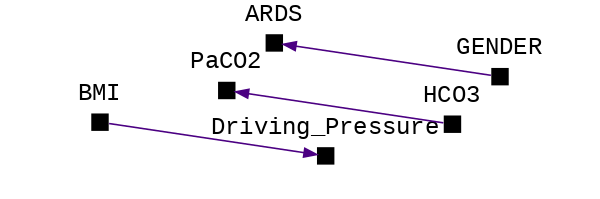

In [145]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.3)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Creatinine', \
  'Driving_Pressure/BMI', 'Tidal_ml/BMI'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'indigo'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

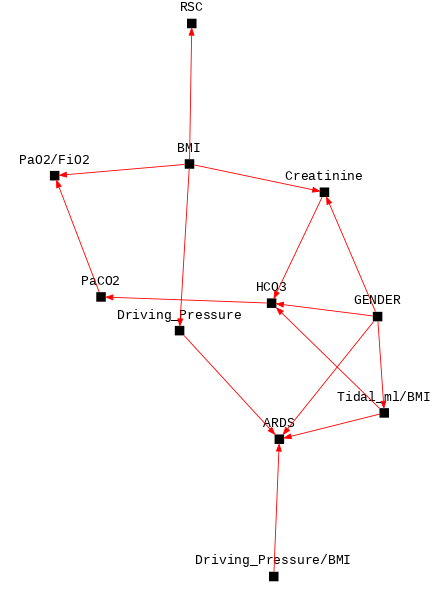

In [193]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.1)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure/BMI', 'RSC')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['AGE'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'red'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

We see that without temporal parameters our structure is not robust. Accordingly we introduce them, now also forbidding trivial edges such as \url{HCO3_Change} $\rightarrow$ \url{HCO3}.

In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2',\
  'Driving_Pressure', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

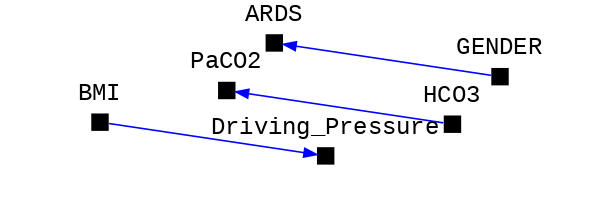

In [269]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.5)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change', 'Creatinine', 'Creatinine Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

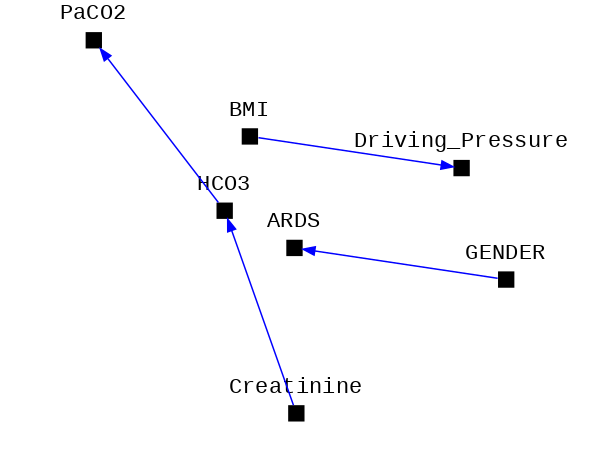

In [270]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.3)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI'), ('RSC_Change', 'Tidal_ml_Change'), \
  ('Driving_Pressure', 'Driving_Pressure/BMI_Change'), \
  ('Driving_Pressure/BMI', 'Driving_Pressure/BMI_Change'), ('PaO2/FiO2', \
  'PaO2/FiO2_Change')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change', 'Creatinine Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Once again our structure does not appear robust; this time we try changing our temporal parameters to absolute daily differences to see if we can find a strong SCM.

In [0]:
df_e = df_enc.copy()

df_e = add_series_list(['Creatinine', 'PaO2/FiO2', 'RSC', 'HCO3', 'PaCO2',\
  'Driving_Pressure', 'Driving_Pressure/BMI', 'Tidal_ml/BMI'])
df_e = impute(df_e)

drops = ['HADM_ID', 'CHARTDATE']
df_e = df_e.drop(columns=drops)

In [0]:
sm = from_pandas(df_e, tabu_child_nodes=['GENDER', 'AGE', 'BMI'], \
  tabu_parent_nodes=['ARDS'])

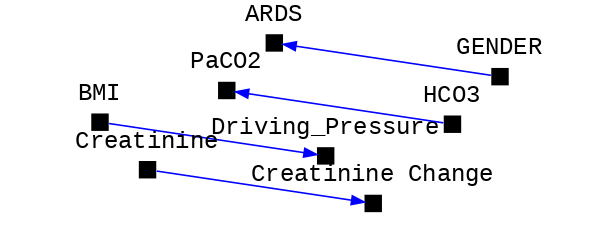

In [234]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.5)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

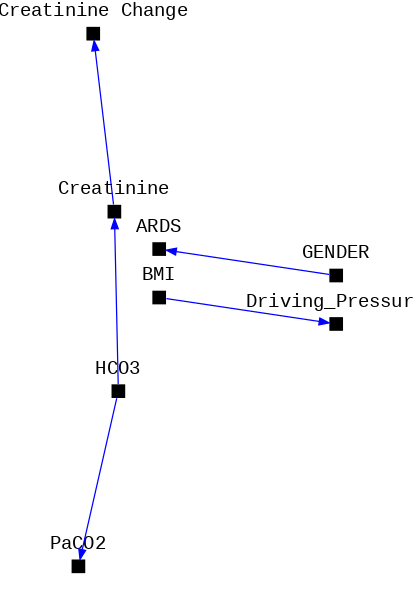

In [239]:
sm_t = sm.copy()
sm_t.remove_edges_below_threshold(0.2)
forbidden_edges = [('BMI', 'Driving_Pressure/BMI'), ('Driving_Pressure/BMI', \
  'Driving_Pressure'), ('Tidal_ml', 'Driving_Pressure/BMI'), ('Tidal_ml/BMI',\
  'RSC'), ('Driving_Pressure/BMI','Tidal_ml/BMI'), ('BMI','Tidal_ml/BMI'), \
  ('Driving_Pressure','Tidal_ml/BMI'), ('Driving_Pressure_Change', \
  'Driving_Pressure/BMI'), ('RSC_Change', 'Tidal_ml_Change'), \
  ('Driving_Pressure', 'Driving_Pressure/BMI_Change'), \
  ('Driving_Pressure/BMI', 'Driving_Pressure/BMI_Change'), ('PaO2/FiO2', \
  'PaO2/FiO2_Change')]
sm_t.remove_edges_from(forbidden_edges)

sm_t.remove_nodes_from(['RSC', 'PaO2/FiO2', 'AGE', 'Tidal_ml/BMI', \
  'Driving_Pressure/BMI', 'PaO2/FiO2 Change', 'RSC Change', 'HCO3 Change', \
  'PaCO2 Change', 'Driving_Pressure Change', 'Tidal_ml/BMI Change', \
  'Driving_Pressure/BMI Change'])

viz = plot_structure(
    sm_t,
    all_node_attributes={'color': None, 'shape': 'square', \
      'fillcolor': 'black', 'fontcolor': 'black', 'fontname': 'courier'},
    all_edge_attributes={'color': 'blue'},
    graph_attributes={'bgcolor': 'white', 'size': 2})
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)